# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

plt.rcParams["figure.figsize"] = [14, 7]
warnings.filterwarnings('ignore')

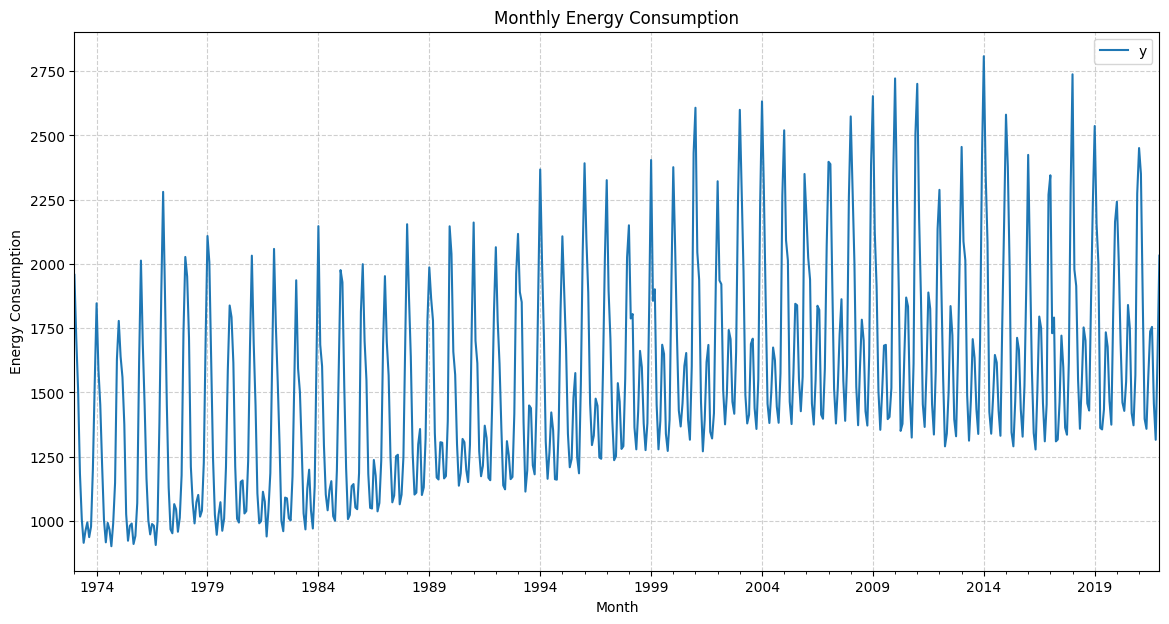

In [2]:
path = Path('../../datasets/Ch13/')
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)

energy.columns = ['y'] # rename column for clarity
energy.index.freq = 'MS' #set frequency
energy.plot(title='Monthly Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [3]:
print("Original Data Info:")
energy.info()
print(f"\nOriginal Data Head:\n{energy.head()}")

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB

Original Data Head:
                   y
Month               
1973-01-01  1957.641
1973-02-01  1712.143
1973-03-01  1510.079
1973-04-01  1183.421
1973-05-01  1006.326


In [4]:
# --- Preprocessing Functions ---

def fill_missing_forward(df):
    """
    Checks for missing data and fills using forward fill.

    Args:
        df (pd.DataFrame): DataFrame with a time series in a column named 'y'

    Returns:
        pd.DataFrame: DataFrame with missing values filled.
    """
    n_missing = int(df['y'].isna().sum()) # Assuming single column 'y'
    if n_missing > 0:
        print(f'Found {n_missing} missing observations... filling forward.')
        df = df.ffill()
    return df

In [5]:
en_df = fill_missing_forward(energy)

# Forecasting with LSTM

## Using Keras: One-Step Forecasting (Short-Term)

In [6]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import (EarlyStopping, 
                                        ReduceLROnPlateau, 
                                        TensorBoard,
                                        ModelCheckpoint)
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

In [7]:
# This is added for Reproducibility
import random 
import tensorflow as tf

SEED = 42 
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
def create_sequences(df, window_size, target_col='y'):
    """
    Convert a time series into a supervised learning dataset with lagged features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series data with single target column
    window_size : int
        Number of lagged observations to use as input features
    target_col : str, optional
        Name of the column in 'df' that contains the target time series values.
        Default is 'y'
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with lagged features (x1, x2, ...) and target (y)
    """
    try:
        # Extract the target column as a 1D NumPy array
        data_values = df[target_col].values 
    except KeyError:
        raise KeyError(f"""Column '{target_col}' not found in DataFrame. 
                        Please ensure the target column is correctly named.""")

    X_list = [data_values[i:i+window_size] for i in range(len(data_values)-window_size)]
    X = np.array(X_list) # Creates a 2D array (num_sequences, window_size)
    
    # Target is the value immediately following each window
    y_values = data_values[window_size:]
    idx = df.index[window_size:]

    feature_cols = [f'x{i+1}' for i in range(window_size)]

    seq_df = pd.DataFrame(X, columns=feature_cols, index=idx)
    # Assign the target values to a column named 'y' in the new DataFrame
    seq_df['y'] = y_values

    return seq_df

In [9]:
en_seq = create_sequences(en_df, 12)
en_seq.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y
Month,,,,,,,,,,,,,
1974-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930
1974-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448
1974-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073
1974-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073,1215.228
1974-05-01,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073,1215.228,1003.821


In [10]:
en_seq.shape

(576, 13)

In [11]:
class TimeSeriesStandardScaler:
    """
    Standardizes time series data and provides train/val/test splits.
    """
    def __init__(self, df, test_size, val_size):
        """
        Initializes the preprocessor.

        Args:
            df (pd.DataFrame): The DataFrame containing sequences (features and target).
            test_size (int): Number of periods for the test set.
            val_size (int): Number of periods for the validation set.
        """
        self.data = df
        self.test_periods = test_size
        self.val_periods = val_size
        self.mu = None
        self.sigma = None
    
    def split_data(self):
        """
        Splits the data into training, validation, and test sets based on time order.
        """
        n_total = len(self.data)
        
        test_start = n_total - self.test_periods
        val_start = test_start - self.val_periods
        # Create splits maintaining temporal order
        train = self.data.iloc[:val_start]
        val = self.data.iloc[val_start:test_start]
        test = self.data.iloc[test_start:]
             
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, val, test
    
    def _transform(self, data):
        if self.mu is None or self.sigma is None:
            raise ValueError("Scaler not fitted yet. Call fit_transform() first.")
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        """
        Fits the scaler on the training data and transforms train, val, and test sets.
        Scales all features and target using the same parameters derived from the training data.
        """
        train, val, test = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_scaled = self._transform(train)
        test_scaled = self._transform(test)
        val_scaled = self._transform(val)
        return train_scaled, val_scaled, test_scaled
    
    def inverse_transform(self, data):
        """
        Reverses the standardization transformation.
        """
        return (data * self.sigma)+self.mu
        
    def inverse_transform_target(self, data):
        """
        Reverses standardization for target variable only.
        Assumes target is the last column in the original DataFrame.
        """
        return (data * self.sigma[-1])+self.mu[-1]

In [12]:
scaler = TimeSeriesStandardScaler(en_seq, test_size=12, val_size=36)
k_train_scaled, k_val_scaled, k_test_scaled = scaler.fit_transform()

In [13]:
print(f'''
original: {energy.shape}
sequence_df: {en_seq.shape}
train_scaled: {k_train_scaled.shape}
val_scaled: {k_val_scaled.shape}
test_scaled: {k_test_scaled.shape}
''')


original: (588, 1)
sequence_df: (576, 13)
train_scaled: (528, 13)
val_scaled: (36, 13)
test_scaled: (12, 13)



In [14]:
def prepare_keras_input(*args):
    """
    Converts DataFrames to 3D tensors for LSTM models.
    
    Parameters:
    -----------
    *args : list of pandas.DataFrame
        DataFrames with:
            - Feature columns (x1, x2, ...)
            - Target column 'y'   
    Returns:
    --------
    tuple
        Tuple containing target arrays followed by feature arrays for each input DataFrame
    """
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1) for col in args]
    
    return *y, *x

In [15]:
 # For Keras/TensorFlow
(y_train_k, 
 y_val_k, 
 y_test_k, 
 x_train_k, 
 x_val_k, 
 x_test_k) = prepare_keras_input(k_train_scaled.copy(), 
                                  k_val_scaled.copy(), 
                                  k_test_scaled.copy())

In [16]:
print(f"x_train_k shape: {x_train_k.shape}")  
print(f"y_train_k shape: {y_train_k.shape}")  

x_train_k shape: (528, 12, 1)
y_train_k shape: (528, 1)


```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units))
model.add(Dense(1)) 
```

adding Dropout

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units))
model.add(Dropout(dropout_rate))
model.add(Dense(1)) 
```

adding another LSTM and Dropout layers

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=units//2))  # Second LSTM layer with fewer units
model.add(Dropout(dropout_rate))
model.add(Dense(1))
```

In [17]:
def create_keras_lstm_model(input_shape, units=32, dropout_rate=0.2):
    """
    Creates a stacked Keras LSTM model for time series forecasting.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features). Example: (WINDOW_SIZE, 1).
        units (int): Number of units in the first LSTM layer.
                     The second LSTM layer will use units//2
        dropout_rate (float): Dropout rate after each LSTM layer.
    Returns:
        keras.Model: Compiled Keras model.
    """
    model = Sequential()
    # Input shape expected by LSTM: (batch_size, timesteps, features)
    # We provide (timesteps, features) via input_shape
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))  # Second LSTM layer with fewer units
    model.add(Dropout(dropout_rate))
    model.add(Dense(1)) # Output layer for forecasting

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(name='rmse'),
                           MeanAbsoluteError(name='mae')])
    return model


In [18]:
keras_input_shape = (x_train_k.shape[1], x_train_k.shape[2])

keras_lstm_model = create_keras_lstm_model(input_shape=keras_input_shape,
                                     units=32,
                                     dropout_rate=0.2)
keras_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def train_keras_model(model, x_train, y_train, x_val, y_val,
                      epochs=500, 
                      patience=15,
                      batch_size=32):
    """
    Trains the Keras model with early stopping.

    Args:
        model (keras.Model): The compiled Keras model.
        x_train, y_train: Training data and targets.
        x_val, y_val: Validation data and targets.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs with no improvement to wait before stopping.
        batch_size (int): Training batch size.

    Returns:
        keras.callbacks.History: Training history object.
    """
    print(f"\nTraining Keras model for max {epochs} epochs (patience={patience}, batch_size={batch_size})...")
    early_stopping = EarlyStopping(monitor="val_loss",
                                   patience=patience,
                                   min_delta=0.001, # Small improvement threshold
                                   restore_best_weights=True, # Restore weights from best epoch
                                   verbose=1) 

    # persisting model best weights
    model_checkpoint = ModelCheckpoint(
        filepath='./logs/best_model.keras',
        monitor="val_loss",
        save_best_only=True,
        mode="min",
        verbose=1,
        save_freq="epoch")

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=patience//3, 
                                  min_lr=1e-6,
                                  verbose=1)
    
    tensorboard= TensorBoard(log_dir='./logs', 
                             histogram_freq=1)

    history = model.fit(x_train, y_train,
                        shuffle=False, # Important for time series
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, 
                                   reduce_lr, 
                                   tensorboard,
                                   model_checkpoint],
                        verbose=1) # Set to 1 or 2 for progress, 0 for silent
    print("Keras training complete.")
    return history

In [20]:
history_lstm_keras = train_keras_model(
    keras_lstm_model,
    x_train_k, y_train_k,
    x_val_k, y_val_k,
    epochs=500,
    patience=15,
    batch_size=32)


Training Keras model for max 500 epochs (patience=15, batch_size=32)...
Epoch 1/500
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0383 - mae: 0.8907 - rmse: 1.0169   
Epoch 1: val_loss improved from inf to 0.97812, saving model to ./logs/best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0285 - mae: 0.8713 - rmse: 1.0125 - val_loss: 0.9781 - val_mae: 0.7380 - val_rmse: 0.9890 - learning_rate: 0.0010
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8232 - mae: 0.8002 - rmse: 0.9068 
Epoch 2: val_loss improved from 0.97812 to 0.76389, saving model to ./logs/best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8226 - mae: 0.7980 - rmse: 0.9065 - val_loss: 0.7639 - val_mae: 0.6992 - val_rmse: 0.8740 - learning_rate: 0.0010
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6870 - mae: 0.6994 - rmse: 0.8283 
Epoch 3: val_loss improved from 0.76389 to 0.63694, saving model to ./logs/best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

In [21]:
%load_ext tensorboard
%tensorboard --logdir=./logs

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_forecast(model, x_test, y_test, test_index, history, preprocessor_instance):
    """
    Plots training loss and actual vs forecasted values for Keras model.

    Args:
        model (keras.Model): Trained Keras model.
        x_test (np.ndarray): Scaled test features.
        y_test (np.ndarray): Scaled test target.
        test_index (pd.Index): Datetime index for the test set.
        history (keras.callbacks.History): Training history object.
        preprocessor_instance (TimeSeriesStandardScaler): 
                The fitted preprocessor object used for inverse scaling.
    """
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Training and Validation Loss
    # Training loss plot
    pd.Series(history.history['loss']).plot(
                       style='k--',
                       alpha=0.50, 
                       title='Keras Model Loss per Epoch',
                       ax = ax[0], 
                       label='Training loss')
    
    # Validation loss plot
    pd.Series(history.history['val_loss']).plot(
                      style='k',
                      ax=ax[0],
                      label='Validation loss')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.5)

    
    # Plot 2: Actual vs Predicted Values
    # Get predictions
    predicted = model.predict(x_test)
    # Inverse transform predictions and actual values to original scale
    predicted_original = preprocessor_instance.inverse_transform_target(predicted)
    y_test_original = preprocessor_instance.inverse_transform_target(y_test)

    # Plot actual values
    pd.Series(y_test_original.reshape(-1), 
              index=test_index).plot(
                                style='k--', 
                                alpha=0.5, 
                                ax=ax[1], 
                                title='Keras LSTM One-Step Forecast vs Actual (Test Set)',
                                label='Actual')
    pd.Series(predicted_original.reshape(-1), 
              index=test_index).plot(
                                style='k',
                                label='Forecast', 
                                ax=ax[1])
    fig.tight_layout()
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.5)
    ax[1].set_xlabel('Month')
    ax[1].set_ylabel('Energy Consumption')
    plt.show()

    mae_keras = mean_absolute_error(y_test_original, predicted_original)
    rmse_keras = np.sqrt(mean_squared_error(y_test_original, predicted_original))
    print(f"Keras Test Set MAE:  {mae_keras:.4f}") 
    print(f"Keras Test Set RMSE: {rmse_keras:.4f}") 

In [23]:
history_lstm_keras.history.keys()

dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'learning_rate'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


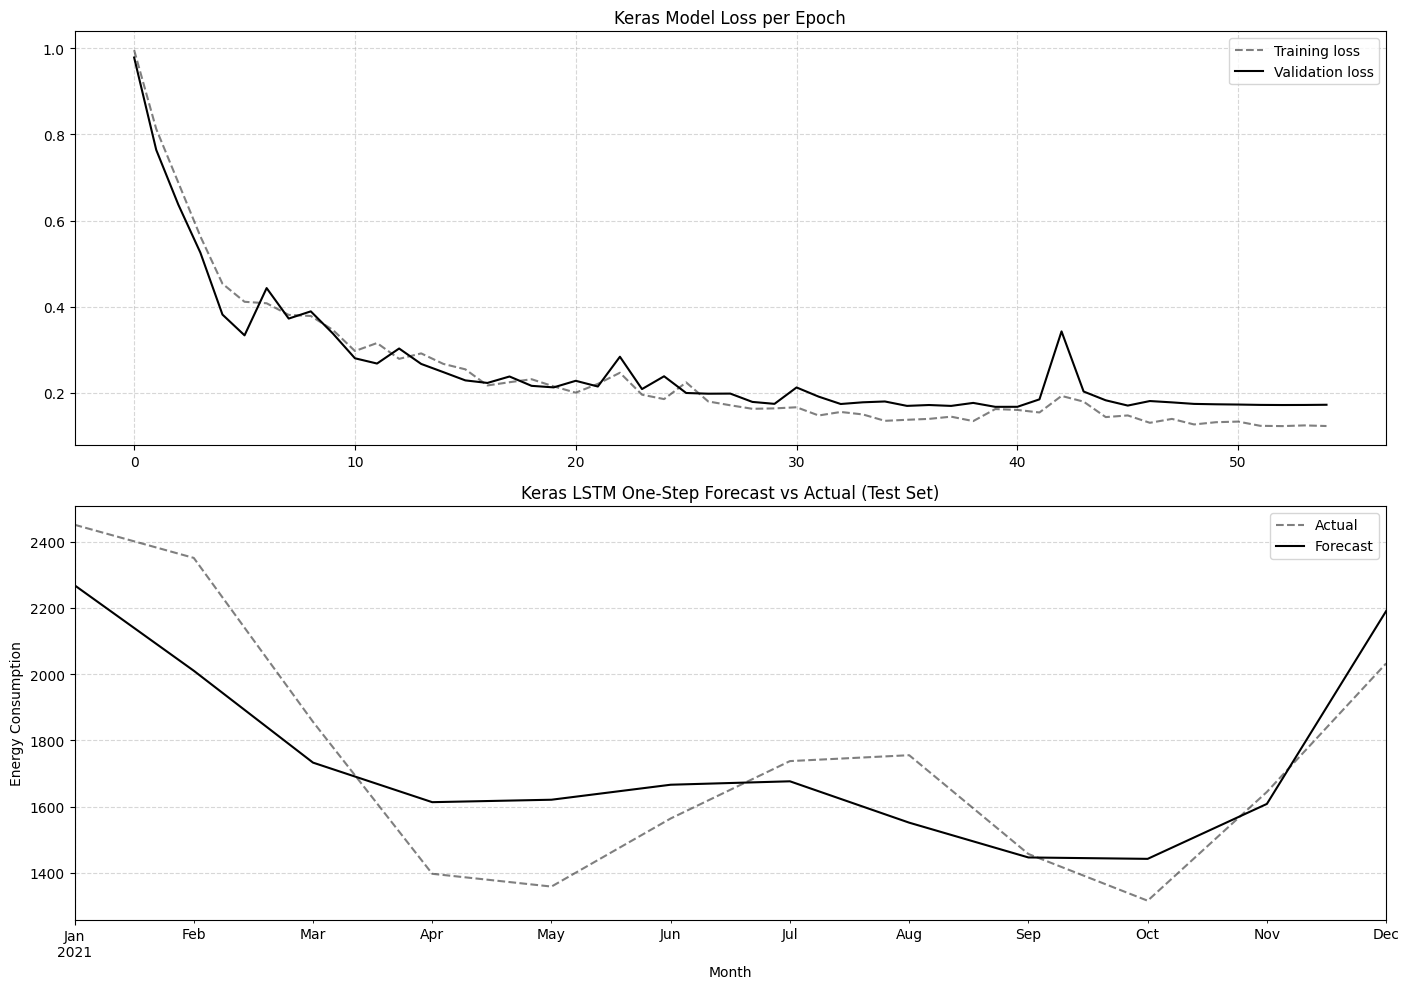

Keras Test Set MAE:  151.8853
Keras Test Set RMSE: 177.5005


In [24]:
plot_forecast(keras_lstm_model, 
              x_test_k, 
              y_test_k, 
              k_test_scaled.index, 
              history_lstm_keras, scaler)

## Using Keras: Multistep forecast

In [25]:
# def create_keras_lstm_nsteps_model(input_shape, units=32, dropout_rate=0.2, n_steps=7):
#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     model.add(LSTM(units=units, return_sequences=True))
#     model.add(Dropout(dropout_rate))
#     model.add(LSTM(units=units))  # Returns last output vector
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(n_steps))  # Predict n_steps future values
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                   loss='mean_squared_error',
#                   metrics=[RootMeanSquaredError(name='rmse'),
#                            MeanAbsoluteError(name='mae')])
#     return model


In [26]:
# keras_lstm_nsteps_model = create_keras_lstm_nsteps_model(input_shape=keras_input_shape,
#                                      units=32,
#                                      dropout_rate=0.2,
#                                      n_steps=12)
# keras_lstm_nsteps_model.summary()

In [27]:
# history_lstm_nsteps_keras = train_keras_model(
#     keras_lstm_nsteps_model,
#     x_train_k, y_train_k,
#     x_val_k, y_val_k,
#     epochs=500,
#     patience=15,
#     batch_size=32
# )

In [28]:
# predicted = keras_lstm_nsteps_model.predict(x_test_k)
# predicted_original = scaler.inverse_transform_target(predicted)
# y_test_original = scaler.inverse_transform_target(y_test_k)

In [29]:
# # Inverse transform predictions and actual values to original scale
# predicted_original = preprocessor_instance.inverse_transform_target(predicted)
# y_test_original = preprocessor_instance.inverse_transform_target(y_test)

In [30]:
# predicted_original.shape

In [31]:
# predicted_original

In [32]:
# y_test_original.shape

In [33]:
# mae_keras = mean_absolute_error(y_test_k, predicted_original)
# rmse_keras = np.sqrt(mean_squared_error(y_test_original, predicted_original))
# print(f"Keras Test Set MAE:  {mae_keras:.4f}") 
# print(f"Keras Test Set RMSE: {rmse_keras:.4f}") 

## Using Darts RNNModel for LSTM

In [34]:
import darts
darts.__version__

'0.35.0'

In [35]:
from darts.models import RNNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mae
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

In [36]:
en_cp = en_df.copy().reset_index()
ts = TimeSeries.from_dataframe(en_cp, 
                               time_col='Month', 
                               value_cols='y', 
                               freq='MS')
ts = ts.astype(np.float32)

In [37]:
n_total = len(ts)
n_test = 12 
n_val = 36 

# Calculate split indices
test_start = n_total - n_test
val_start = test_start - n_val
        
# Create splits maintaining temporal order
d_train = ts[:val_start]
d_val = ts[val_start:test_start]
d_test = ts[test_start:]

print(f'''
train: {len(d_train)}
val : {len(d_val)}
test: {len(d_test)}''')


train: 540
val : 36
test: 12


In [38]:
from sklearn.preprocessing import StandardScaler
d_scaler = Scaler(StandardScaler())

d_train_scaled = d_scaler.fit_transform(d_train)
d_val_scaled = d_scaler.transform(d_val)
d_test_scaled = d_scaler.transform(d_test)
d_series = d_scaler.transform(ts)

In [39]:
# Darts LSTM parameters
darts_lstm_params = {
    'model':'LSTM',            # Specify the RNN type
    'input_chunk_length': 12,  # How many time steps the model sees (your 'window'),
    'training_length': 13,
    'hidden_dim': 32,  # LSTM units
    'n_rnn_layers': 2, # Number of LSTM layers
    'dropout': 0.2,    # Dropout rate
    'batch_size': 32,  # Batch size for training
    'n_epochs': 500,   # Max number of epochs
    'optimizer_kwargs': {'lr': 0.001}, # Adam is default
    'random_state': 42, # For reproducibility
    'force_reset':True  # Ensure fresh model training
}

PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,   # Early stopping patience
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, # Show training progress bar
    "accelerator":"gpu", "devices": [0], # Use GPU for training
    #"accelerator":"cpu" # Use CPU for training
}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }

darts_lstm_model = RNNModel(
    **darts_lstm_params,
    model_name='energy_lstm',
    log_tensorboard=True,       # Set True to use TensorBoard
    save_checkpoints=True,      # Set True to save model checkpoints
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

In [40]:
darts_lstm_model.fit(d_train_scaled,
                     val_series=d_val_scaled,
                     verbose=True) # verbose=True shows epoch progress

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 57.08it/s, v_num=logs, train_loss=0.930]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 55.11it/s, v_num=logs, train_loss=0.930, val_loss=0.959]

Metric val_loss improved. New best score: 0.959


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.02it/s, v_num=logs, train_loss=0.881, val_loss=0.959]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 121.32it/s, v_num=logs, train_loss=0.881, val_loss=0.943]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.943


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 124.74it/s, v_num=logs, train_loss=0.587, val_loss=0.943]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 115.92it/s, v_num=logs, train_loss=0.587, val_loss=0.858]

Metric val_loss improved by 0.085 >= min_delta = 0.001. New best score: 0.858


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.46it/s, v_num=logs, train_loss=0.374, val_loss=0.858]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 122.77it/s, v_num=logs, train_loss=0.374, val_loss=0.720]

Metric val_loss improved by 0.138 >= min_delta = 0.001. New best score: 0.720


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.04it/s, v_num=logs, train_loss=0.364, val_loss=0.720]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 119.95it/s, v_num=logs, train_loss=0.364, val_loss=0.593]

Metric val_loss improved by 0.127 >= min_delta = 0.001. New best score: 0.593


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 133.71it/s, v_num=logs, train_loss=0.413, val_loss=0.593]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 124.33it/s, v_num=logs, train_loss=0.413, val_loss=0.578]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.578


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 128.71it/s, v_num=logs, train_loss=0.280, val_loss=0.578]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 118.83it/s, v_num=logs, train_loss=0.280, val_loss=0.565]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.565


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 134.76it/s, v_num=logs, train_loss=0.334, val_loss=0.565]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 124.60it/s, v_num=logs, train_loss=0.334, val_loss=0.551]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.551


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.92it/s, v_num=logs, train_loss=0.291, val_loss=0.551]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 122.94it/s, v_num=logs, train_loss=0.302, val_loss=0.551]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 111.61it/s, v_num=logs, train_loss=0.302, val_loss=0.541]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.541


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.96it/s, v_num=logs, train_loss=0.263, val_loss=0.541]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 118.53it/s, v_num=logs, train_loss=0.263, val_loss=0.516]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.516


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.40it/s, v_num=logs, train_loss=0.240, val_loss=0.516]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.07it/s, v_num=logs, train_loss=0.231, val_loss=0.537]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.59it/s, v_num=logs, train_loss=0.227, val_loss=0.526]
Valid

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.514


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 133.07it/s, v_num=logs, train_loss=0.178, val_loss=0.514]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 122.86it/s, v_num=logs, train_loss=0.178, val_loss=0.501]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.501


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.07it/s, v_num=logs, train_loss=0.201, val_loss=0.501]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 133.41it/s, v_num=logs, train_loss=0.187, val_loss=0.537]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.47it/s, v_num=logs, train_loss=0.198, val_loss=0.511]
Valid

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.488


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 123.89it/s, v_num=logs, train_loss=0.155, val_loss=0.488]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 113.96it/s, v_num=logs, train_loss=0.155, val_loss=0.476]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.476


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 116.42it/s, v_num=logs, train_loss=0.190, val_loss=0.476]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 108.26it/s, v_num=logs, train_loss=0.190, val_loss=0.470]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.470


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.28it/s, v_num=logs, train_loss=0.145, val_loss=0.470]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 120.57it/s, v_num=logs, train_loss=0.145, val_loss=0.459]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.459


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.05it/s, v_num=logs, train_loss=0.187, val_loss=0.459]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.30it/s, v_num=logs, train_loss=0.164, val_loss=0.481]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.92it/s, v_num=logs, train_loss=0.177, val_loss=0.461]
Valid

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.456


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.39it/s, v_num=logs, train_loss=0.184, val_loss=0.456]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.69it/s, v_num=logs, train_loss=0.205, val_loss=0.473]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.59it/s, v_num=logs, train_loss=0.164, val_loss=0.469]
Valid

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.446


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.89it/s, v_num=logs, train_loss=0.153, val_loss=0.446]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 122.44it/s, v_num=logs, train_loss=0.153, val_loss=0.445]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.445


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 133.41it/s, v_num=logs, train_loss=0.159, val_loss=0.445]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 124.05it/s, v_num=logs, train_loss=0.159, val_loss=0.438]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.438


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.77it/s, v_num=logs, train_loss=0.132, val_loss=0.438]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.64it/s, v_num=logs, train_loss=0.132, val_loss=0.426]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.426


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 136.71it/s, v_num=logs, train_loss=0.144, val_loss=0.426]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 126.61it/s, v_num=logs, train_loss=0.144, val_loss=0.417]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.417


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.92it/s, v_num=logs, train_loss=0.167, val_loss=0.417]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 122.70it/s, v_num=logs, train_loss=0.154, val_loss=0.429]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 113.51it/s, v_num=logs, train_loss=0.154, val_loss=0.408]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.408


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.80it/s, v_num=logs, train_loss=0.178, val_loss=0.408]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.70it/s, v_num=logs, train_loss=0.0994, val_loss=0.415]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 140.60it/s, v_num=logs, train_loss=0.151, val_loss=0.419]
Valid

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.389


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 142.59it/s, v_num=logs, train_loss=0.125, val_loss=0.389]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.57it/s, v_num=logs, train_loss=0.125, val_loss=0.378]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.378


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 145.40it/s, v_num=logs, train_loss=0.106, val_loss=0.378]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 102.56it/s, v_num=logs, train_loss=0.149, val_loss=0.393]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 115.39it/s, v_num=logs, train_loss=0.165, val_loss=0.407]
Valid

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.370


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 135.44it/s, v_num=logs, train_loss=0.171, val_loss=0.370]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.78it/s, v_num=logs, train_loss=0.128, val_loss=0.377]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 145.67it/s, v_num=logs, train_loss=0.156, val_loss=0.379]
Valid

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.358


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.73it/s, v_num=logs, train_loss=0.120, val_loss=0.358]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 144.12it/s, v_num=logs, train_loss=0.114, val_loss=0.383]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.60it/s, v_num=logs, train_loss=0.114, val_loss=0.344]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.344


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 135.80it/s, v_num=logs, train_loss=0.140, val_loss=0.344]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.02it/s, v_num=logs, train_loss=0.128, val_loss=0.363]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 142.14it/s, v_num=logs, train_loss=0.154, val_loss=0.346]
Valid

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.318


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 142.13it/s, v_num=logs, train_loss=0.113, val_loss=0.318]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.68it/s, v_num=logs, train_loss=0.135, val_loss=0.333]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.22it/s, v_num=logs, train_loss=0.155, val_loss=0.335]
Valid

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.305


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.12it/s, v_num=logs, train_loss=0.123, val_loss=0.305]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.90it/s, v_num=logs, train_loss=0.123, val_loss=0.301]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.301


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.68it/s, v_num=logs, train_loss=0.134, val_loss=0.301]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.87it/s, v_num=logs, train_loss=0.134, val_loss=0.293]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.293


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.93it/s, v_num=logs, train_loss=0.118, val_loss=0.293]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.81it/s, v_num=logs, train_loss=0.112, val_loss=0.320]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.41it/s, v_num=logs, train_loss=0.124, val_loss=0.310]
Valid

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.284


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 143.98it/s, v_num=logs, train_loss=0.116, val_loss=0.284]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 134.02it/s, v_num=logs, train_loss=0.116, val_loss=0.281]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.281


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 143.21it/s, v_num=logs, train_loss=0.124, val_loss=0.281]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.51it/s, v_num=logs, train_loss=0.112, val_loss=0.288]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 140.21it/s, v_num=logs, train_loss=0.108, val_loss=0.284]
Valid

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.268


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.44it/s, v_num=logs, train_loss=0.110, val_loss=0.268]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 140.13it/s, v_num=logs, train_loss=0.100, val_loss=0.276]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 143.39it/s, v_num=logs, train_loss=0.127, val_loss=0.277]
Valid

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.258


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 141.41it/s, v_num=logs, train_loss=0.122, val_loss=0.258]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 145.08it/s, v_num=logs, train_loss=0.0968, val_loss=0.263]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.98it/s, v_num=logs, train_loss=0.097, val_loss=0.269]
Valid

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.252


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 144.31it/s, v_num=logs, train_loss=0.125, val_loss=0.252]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 135.20it/s, v_num=logs, train_loss=0.125, val_loss=0.241]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.241


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.50it/s, v_num=logs, train_loss=0.132, val_loss=0.241]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.83it/s, v_num=logs, train_loss=0.106, val_loss=0.266]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 143.79it/s, v_num=logs, train_loss=0.115, val_loss=0.245]
Valid

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.236


Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 142.61it/s, v_num=logs, train_loss=0.0943, val_loss=0.236]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.88it/s, v_num=logs, train_loss=0.116, val_loss=0.250]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.58it/s, v_num=logs, train_loss=0.104, val_loss=0.236]
Valid

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.231


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.42it/s, v_num=logs, train_loss=0.127, val_loss=0.231]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.60it/s, v_num=logs, train_loss=0.127, val_loss=0.226]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.226


Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 134.60it/s, v_num=logs, train_loss=0.132, val_loss=0.226]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.09it/s, v_num=logs, train_loss=0.103, val_loss=0.242]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.87it/s, v_num=logs, train_loss=0.142, val_loss=0.235]
Valid

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.224


Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 128.05it/s, v_num=logs, train_loss=0.0908, val_loss=0.224]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 119.45it/s, v_num=logs, train_loss=0.0908, val_loss=0.222]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.222


Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 125.33it/s, v_num=logs, train_loss=0.140, val_loss=0.222]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 116.00it/s, v_num=logs, train_loss=0.140, val_loss=0.219]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.219


Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 135.96it/s, v_num=logs, train_loss=0.143, val_loss=0.219]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 136.06it/s, v_num=logs, train_loss=0.113, val_loss=0.226]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 126.17it/s, v_num=logs, train_loss=0.113, val_loss=0.218]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.218


Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 142.95it/s, v_num=logs, train_loss=0.131, val_loss=0.218]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 134.13it/s, v_num=logs, train_loss=0.0951, val_loss=0.226]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 123.51it/s, v_num=logs, train_loss=0.0951, val_loss=0.215]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.215


Epoch 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.13it/s, v_num=logs, train_loss=0.141, val_loss=0.215]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.32it/s, v_num=logs, train_loss=0.109, val_loss=0.227]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.48it/s, v_num=logs, train_loss=0.109, val_loss=0.205]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.205


Epoch 102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.35it/s, v_num=logs, train_loss=0.124, val_loss=0.205]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 137.99it/s, v_num=logs, train_loss=0.152, val_loss=0.218]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.81it/s, v_num=logs, train_loss=0.126, val_loss=0.216]
Valid

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.199


Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.48it/s, v_num=logs, train_loss=0.111, val_loss=0.199]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 138.53it/s, v_num=logs, train_loss=0.124, val_loss=0.210]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 136.20it/s, v_num=logs, train_loss=0.111, val_loss=0.209]
Valid

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.199. Signaling Trainer to stop.


Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 120.36it/s, v_num=logs, train_loss=0.100, val_loss=0.204]


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, dropout=0.2, training_length=13, input_chunk_length=12, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, model_name=energy_lstm, log_tensorboard=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x31a2c66f0>], 'enable_progress_bar': True, 'accelerator': 'gpu', 'devices': [0]})

In [41]:
%load_ext tensorboard
%tensorboard --logdir=darts_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
best_darts_model = darts_lstm_model.load_from_checkpoint(
                               model_name="energy_lstm", 
                               best=True)
best_darts_model

RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, dropout=0.2, training_length=13, input_chunk_length=12, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, model_name=energy_lstm, log_tensorboard=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x326483e60>], 'enable_progress_bar': True, 'accelerator': 'gpu', 'devices': [0]})

### One-Step Forecast (Similar to Keras)


In [43]:
one_step_forecast_scaled= darts_lstm_model.historical_forecasts(
    series=d_series,
    start=d_test_scaled.start_time(),
    forecast_horizon=1, # We only want one-step-ahead predictions
    stride=1,           # Move one step at a time
    retrain=False,      # Do not retrain the model at each step
    verbose=True
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


In [44]:
one_step_forecast = d_scaler.inverse_transform(one_step_forecast_scaled)

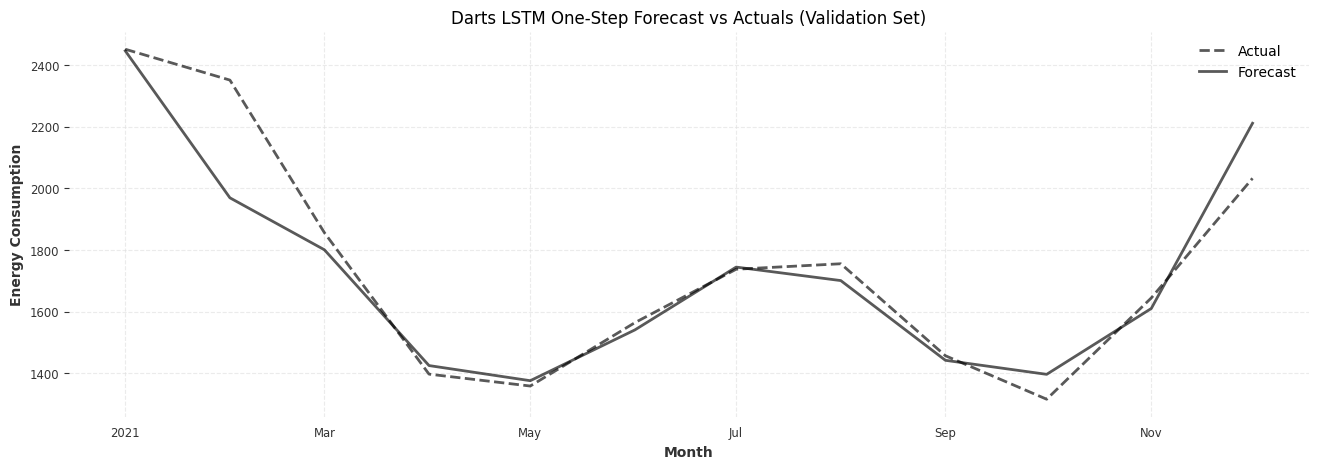

In [45]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
one_step_forecast.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM One-Step Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [46]:
rmse_val = rmse(d_test, one_step_forecast)
mae_val = mae(d_test, one_step_forecast)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")

Darts Validation Set MAE:  73.4404
Darts Validation Set RMSE: 126.9493


### Darts Recursive Forecast 

In [47]:
d_train_val_scaled = d_train_scaled.append(d_val_scaled)
preds_scaled = best_darts_model.predict(n=len(d_test), 
                                  series=d_train_val_scaled)

preds_inv = d_scaler.inverse_transform(preds_scaled)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


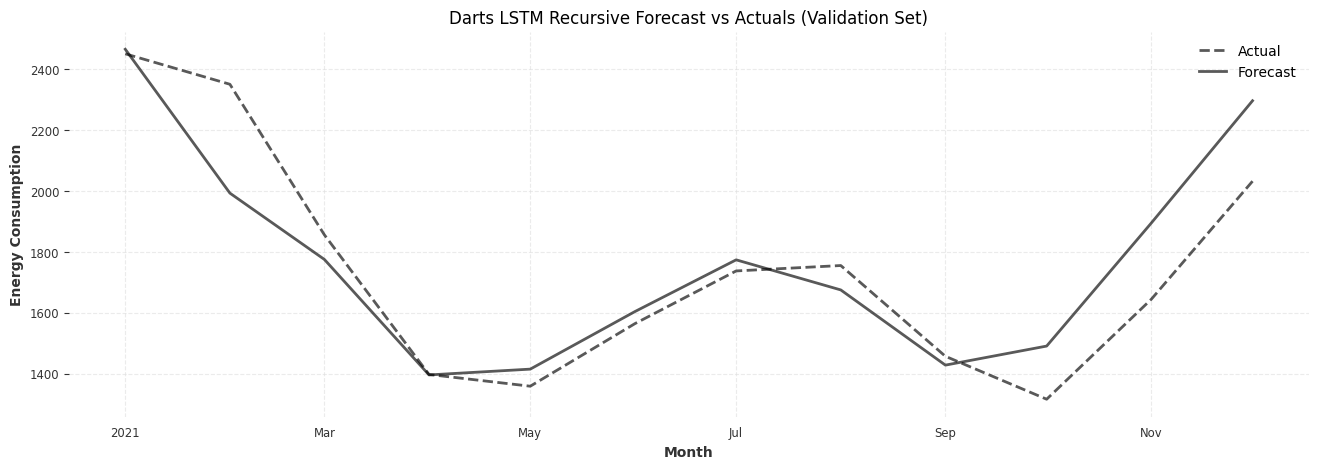

In [48]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
preds_inv.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Recursive Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [49]:
rmse_val = rmse(d_test, preds_inv)
mae_val = mae(d_test, preds_inv)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")


Darts Validation Set MAE:  115.5418
Darts Validation Set RMSE: 161.0847


## Using Darts BlockRNNModel: Long-Term Multioutput

In [50]:
from darts.models import BlockRNNModel

In [51]:
# Darts Block LSTM parameters
darts_blocklstm_params = {
    'model':'LSTM',            # Specify the RNN type
    'input_chunk_length': 24,  # How many time steps the model sees (your 'window')
    'output_chunk_length': 12,  # How many steps the model predicts forward at a time
    'hidden_dim': 32,  # LSTM units
    'n_rnn_layers': 2, # Number of LSTM layers
    'dropout': 0.2,    # Dropout rate
    'batch_size': 32,  # Batch size for training
    'n_epochs': 500,   # Max number of epochs
    'optimizer_kwargs': {'lr': 0.001}, # Adam is default
    'random_state': 42, # For reproducibility
    'force_reset':True  # Ensure fresh model training
}

PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,   # Early stopping patience
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, # Show training progress bar
    "accelerator":"gpu", "devices": [0], # Use GPU for training
    #"accelerator":"cpu" # Use CPU for training
}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }


In [52]:
darts_blocklstm_model = BlockRNNModel(
    **darts_blocklstm_params,
    model_name='energy_blocklstm',
    # log_tensorboard=True,       # Set True to use TensorBoard
    save_checkpoints=True,      # Set True to save model checkpoints
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

In [53]:
darts_blocklstm_model.fit(d_train_scaled,
                     val_series=d_val_scaled,
                     verbose=True) # verbose=True shows epoch progress

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | fc              | Sequential       | 396    | train
-------------------------------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 76.59it/s, train_loss=0.974]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 73.12it/s, train_loss=0.974, val_loss=0.732]

Metric val_loss improved. New best score: 0.732


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 124.15it/s, train_loss=0.843, val_loss=0.732]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.81it/s, train_loss=0.843, val_loss=0.721]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.721


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 121.09it/s, train_loss=0.704, val_loss=0.721]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 110.89it/s, train_loss=0.704, val_loss=0.678]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.678


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 120.54it/s, train_loss=0.618, val_loss=0.678]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 111.70it/s, train_loss=0.618, val_loss=0.638]

Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.638


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 124.88it/s, train_loss=0.458, val_loss=0.638]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.72it/s, train_loss=0.458, val_loss=0.504]

Metric val_loss improved by 0.134 >= min_delta = 0.001. New best score: 0.504


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 124.20it/s, train_loss=0.406, val_loss=0.504]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 114.66it/s, train_loss=0.406, val_loss=0.405]

Metric val_loss improved by 0.099 >= min_delta = 0.001. New best score: 0.405


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 121.94it/s, train_loss=0.307, val_loss=0.405]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 113.61it/s, train_loss=0.307, val_loss=0.357]

Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 0.357


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 127.41it/s, train_loss=0.322, val_loss=0.357]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 117.68it/s, train_loss=0.322, val_loss=0.305]

Metric val_loss improved by 0.052 >= min_delta = 0.001. New best score: 0.305


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 123.99it/s, train_loss=0.253, val_loss=0.305]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 114.55it/s, train_loss=0.253, val_loss=0.254]

Metric val_loss improved by 0.051 >= min_delta = 0.001. New best score: 0.254


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 123.83it/s, train_loss=0.170, val_loss=0.254]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.39it/s, train_loss=0.170, val_loss=0.211]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.211


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 123.70it/s, train_loss=0.176, val_loss=0.211]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 114.77it/s, train_loss=0.176, val_loss=0.189]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.189


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 113.65it/s, train_loss=0.146, val_loss=0.189]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 105.48it/s, train_loss=0.146, val_loss=0.177]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.177


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 117.84it/s, train_loss=0.137, val_loss=0.177]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 108.72it/s, train_loss=0.137, val_loss=0.176]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.176


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 122.03it/s, train_loss=0.126, val_loss=0.176]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 122.93it/s, train_loss=0.142, val_loss=0.176]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 119.96it/s, train_loss=0.108, val_loss=0.187]
Valid

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.167


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 118.52it/s, train_loss=0.138, val_loss=0.167]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 118.94it/s, train_loss=0.111, val_loss=0.172]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 109.86it/s, train_loss=0.111, val_loss=0.164]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.164


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 120.92it/s, train_loss=0.121, val_loss=0.164]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 112.43it/s, train_loss=0.121, val_loss=0.156]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.156


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 116.20it/s, train_loss=0.119, val_loss=0.156]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 119.42it/s, train_loss=0.119, val_loss=0.167]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 118.64it/s, train_loss=0.102, val_loss=0.173]
Valid

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.152


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 118.81it/s, train_loss=0.151, val_loss=0.152]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 117.98it/s, train_loss=0.0929, val_loss=0.158]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 108.91it/s, train_loss=0.0929, val_loss=0.150]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.150


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 120.50it/s, train_loss=0.093, val_loss=0.150]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.34it/s, train_loss=0.139, val_loss=0.162]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 107.08it/s, train_loss=0.139, val_loss=0.147]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.147


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.90it/s, train_loss=0.0962, val_loss=0.147]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 111.71it/s, train_loss=0.0947, val_loss=0.151]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 103.72it/s, train_loss=0.0947, val_loss=0.143]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.143


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 121.07it/s, train_loss=0.104, val_loss=0.143]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 123.29it/s, train_loss=0.105, val_loss=0.148]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 114.44it/s, train_loss=0.105, val_loss=0.138]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.138


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 121.86it/s, train_loss=0.100, val_loss=0.138]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 116.97it/s, train_loss=0.116, val_loss=0.155]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 108.40it/s, train_loss=0.116, val_loss=0.132]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.132


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 118.37it/s, train_loss=0.107, val_loss=0.132]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 113.14it/s, train_loss=0.0974, val_loss=0.164]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.74it/s, train_loss=0.0793, val_loss=0.140]
Valid

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.132. Signaling Trainer to stop.


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 96.70it/s, train_loss=0.0758, val_loss=0.140]


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, input_chunk_length=24, output_chunk_length=12, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, model_name=energy_blocklstm, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x34d295df0>], 'enable_progress_bar': True, 'accelerator': 'gpu', 'devices': [0]})

In [54]:
best_block_model = darts_blocklstm_model.load_from_checkpoint(
                               model_name="energy_blocklstm", 
                               best=True)

In [55]:
d_train_val_scaled = d_train_scaled.append(d_val_scaled)
block_preds_scaled = best_block_model.predict(n=len(d_test), 
                                  series=d_train_val_scaled)
block_preds_inv = d_scaler.inverse_transform(block_preds_scaled)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.31it/s]


In [56]:
rmse_val = rmse(d_test, block_preds_inv)
mae_val = mae(d_test, block_preds_inv)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")

Darts Validation Set MAE:  99.0142
Darts Validation Set RMSE: 120.2867


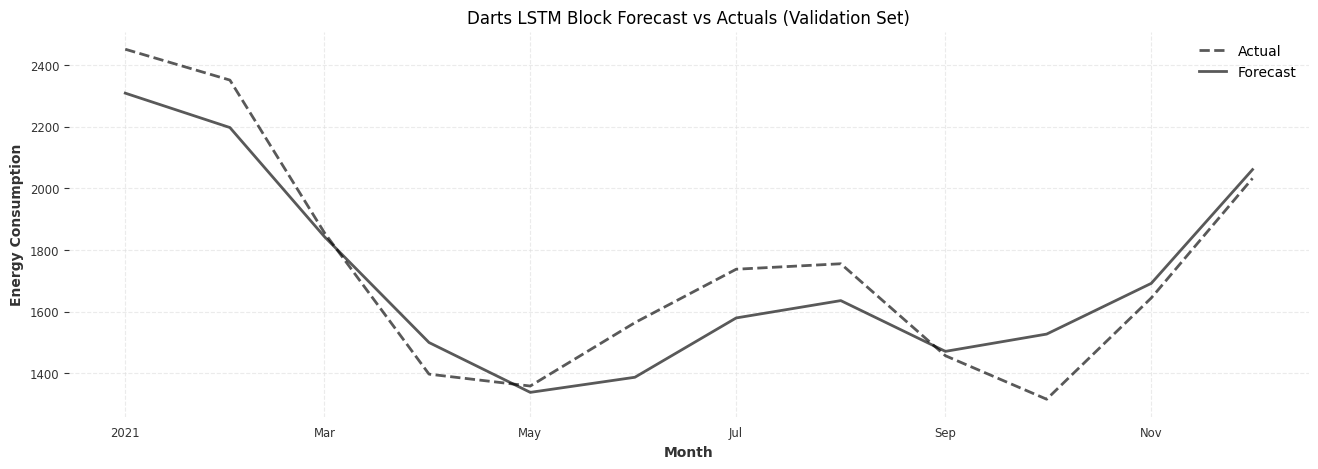

In [57]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
block_preds_inv.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Block Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## NeuralForecast Long-Term Multioutput

In [58]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM as NF_LSTM
from neuralforecast.losses.pytorch import MAE, MSE
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

logger = TensorBoardLogger("nf_tensorboard_log", name="LSTM")

2025-06-28 23:27:18,264	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-28 23:27:18,377	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [59]:
nf_df = energy.copy().reset_index()
nf_df.rename(columns={'Month': 'ds'}, inplace=True)
nf_df['unique_id'] = 'energy' # Add a unique_id column for NeuralForecast
print(nf_df.head())

          ds         y unique_id
0 1973-01-01  1957.641    energy
1 1973-02-01  1712.143    energy
2 1973-03-01  1510.079    energy
3 1973-04-01  1183.421    energy
4 1973-05-01  1006.326    energy


In [60]:
WINDOW_SIZE = 24 # This is `input_size` in NeuralForecast terms
TEST_LENGTH = 12 # Number of steps to forecast, 'h' in NeuralForecast

train_nf = nf_df.iloc[:-TEST_LENGTH]
test_nf = nf_df.iloc[-TEST_LENGTH:]

print(train_nf.shape)
print(test_nf.shape)

(576, 3)
(12, 3)


In [61]:
# Add checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    mode="min",
    save_top_k=1,
)


In [62]:
import math

batch_size = 32
steps_per_epoch = math.ceil(len(train_nf) / batch_size)
steps_per_epoch

18

In [63]:
# NeuralForecast LSTM parameters
PATIENCE = 15
nf_lstm_params = {
    'h': TEST_LENGTH, # Forecast horizon 
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, # Number of layers for the LSTM 
    'encoder_hidden_size': 32, # Hidden state units 
    'encoder_dropout': 0.2, # Dropout regularization applied to LSTM outputs 
    'max_steps': steps_per_epoch * 500, # to match 500 epochs like Keras and Darts
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, # Number of validation iterations before early stopping 
    'val_check_steps': steps_per_epoch, # Number of training steps the model evaluates its performance on val set
    'scaler_type': 'standard', # Type of scaler for normalization 
    'random_seed': 42, # For reproducibility
    'logger': logger, # to use with TensorBoard
  #  'decoder_layers':0, # Set to zero to remove the MLP decoder layer.
    'enable_checkpointing': True,
    'recurrent': False, # True = Recursive while False = Direct
    'callbacks': [checkpoint_callback]
}
# Instantiate the NeuralForecast LSTM model
lstm = NF_LSTM(**nf_lstm_params)

Seed set to 42


In [64]:
# Define the models to be used in NeuralForecast
models = [lstm]

# Create the NeuralForecast object
# The `freq` parameter time series alignment
nf_lstm_model = NeuralForecast(models=models, freq='MS')

# Fit the model. 
#NeuralForecast handles data splitting internally for validation
nf_lstm_model.fit(df=train_nf, val_size= 36) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.42it/s, v_num=0, train_loss_step=0.735, train_loss_epoch=0.760]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.57it/s, v_num=0, train_loss_step=0.445, train_loss_epoch=0.466, valid_loss=264.0]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.47it/s, v_num=0, train_loss_step=0.327, train_loss_epoch=0.332, valid_loss=150.0]
Valid

In [65]:
%load_ext tensorboard
%tensorboard --logdir=nf_tensorboard_log/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [66]:
# Make predictions. The `predict` method uses the `h` defined in the model.
# It forecasts from the end of the `df` used in `fit`.
nf_forecast = nf_lstm_model.predict()
len(nf_forecast)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


12

In [67]:
nf_forecast.columns

Index(['unique_id', 'ds', 'LSTM'], dtype='object')

In [68]:
# Extract the predictions for our 'energy' unique_id and set the index
nf_forecast_df = nf_forecast[nf_forecast['unique_id'] == 'energy'].set_index('ds')
nf_forecast_df = nf_forecast_df[['LSTM']] # Select the 'LSTM' column, which contains the predictions
nf_forecast_df.head()

,LSTM
ds,
2021-01-01,2264.063965
2021-02-01,2017.535645
2021-03-01,1767.371216
2021-04-01,1536.106567
2021-05-01,1522.890259


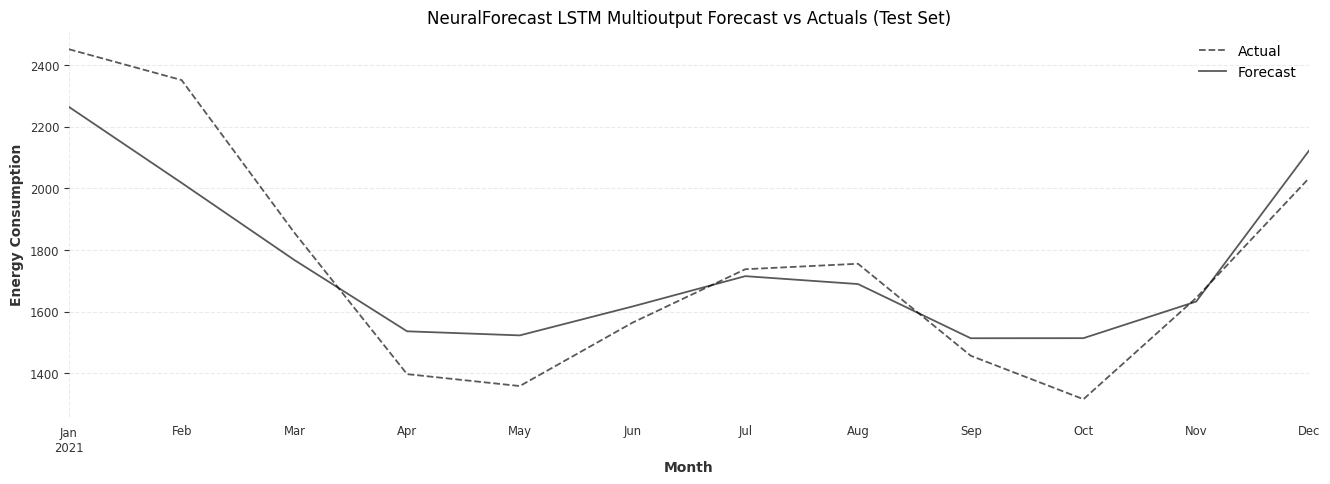

NeuralForecast Test Set MAE:  117.4197
NeuralForecast Test Set RMSE: 146.7713


In [69]:
# Prepare the actual test data for plotting
test_nf.set_index('ds', inplace=True)

plt.figure(figsize=(16, 5))
test_nf['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_forecast_df['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast LSTM Multioutput Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate metrics
mae_nf = mean_absolute_error(test_nf['y'], nf_forecast_df['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(test_nf['y'], nf_forecast_df['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

## There is More

### Keras


In [70]:
# manually loading best weights
keras_lstm_model.load_weights('./logs/best_model.keras')


### Darts 

In [71]:
pred_scaled_lm = darts_lstm_model.predict(n=len(d_test), series=d_train_val_scaled)
pred_inv_lm = d_scaler.inverse_transform(pred_scaled_lm)

rmse_val = rmse(d_test, pred_inv_lm)
mae_val = mae(d_test, pred_inv_lm)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.07it/s]
Darts Validation Set MAE:  123.2744
Darts Validation Set RMSE: 172.2344


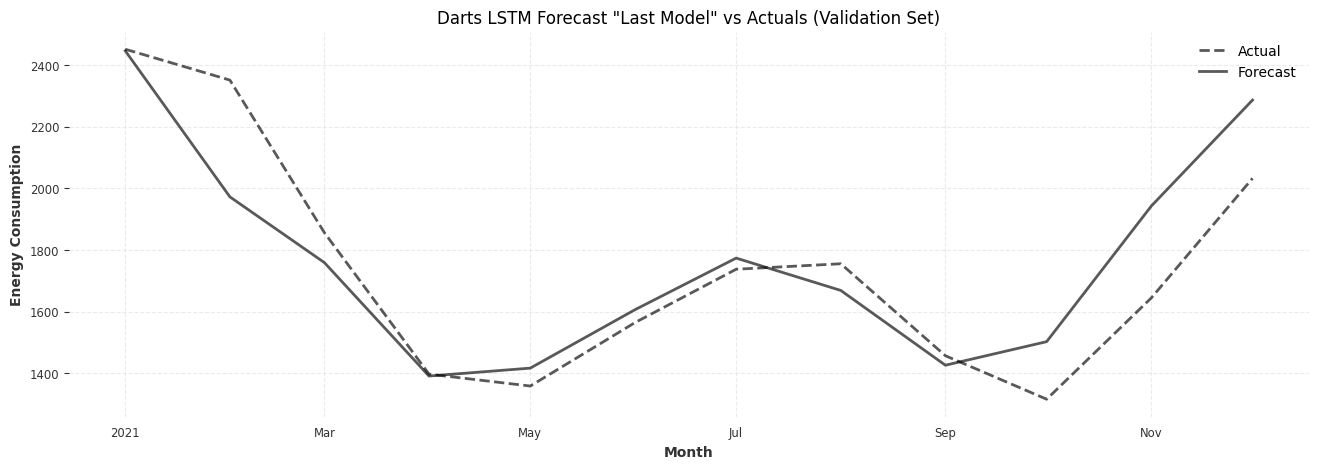

In [72]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
pred_inv_lm.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Forecast "Last Model" vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### NeuralForecast: Loading Best Model

In [73]:
# Rebuild parameters with early stopping disabled
reload_params = nf_lstm_params.copy()
reload_params.update({
    'max_steps': 0,                  # Prevent training
    'early_stop_patience_steps': -1, # Disable NeuralForecast's auto EarlyStopping
})
reload_params.pop('callbacks', None) # Remove any callback references

In [74]:
checkpoint_path = 'nf_tensorboard_log/LSTM/version_0/checkpoints/epoch=269-step=270.ckpt'
nf_best_model = NF_LSTM.load_from_checkpoint(checkpoint_path, **reload_params )

Seed set to 42


In [75]:
nf_loaded = NeuralForecast(models=[nf_best_model], freq='MS')
nf_loaded.fit(df=train_nf, val_size=0)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)
9         Modules in train mode
1         Modules in eval mode


`Trainer.fit` stopped: `max_steps=0` reached.


In [76]:
nf_best_preds = nf_loaded.predict()
# Extract the predictions for our 'energy' unique_id and set the index
nf_forecast_bm = nf_best_preds[nf_best_preds['unique_id'] == 'energy'].set_index('ds')
nf_forecast_bm = nf_forecast_bm[['LSTM']]

# Calculate metrics
mae_nf = mean_absolute_error(test_nf['y'], nf_forecast_bm['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(test_nf['y'], nf_forecast_bm['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.74it/s]
NeuralForecast Test Set MAE:  133.8668
NeuralForecast Test Set RMSE: 177.8046


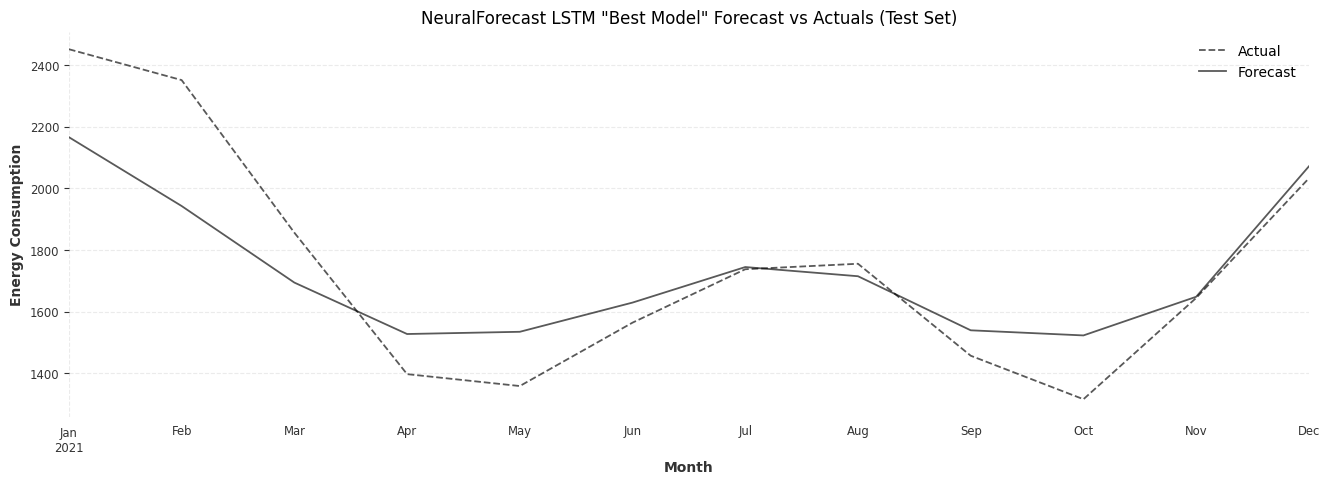

In [77]:
plt.figure(figsize=(16, 5))
test_nf['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_forecast_bm['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast LSTM "Best Model" Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Multivariate Time Series

Components Descriptions:

* Value_NE5 : Households & SMEs electricity consumption (low voltage, grid level 7) in kWh
* Value_NE7 : Business and services electricity consumption (medium voltage, grid level 5) in kWh
* Hr [%Hr] : Relative humidity
* RainDur [min] : Duration of precipitation (divided by 4 for conversion from hourly to quarter-hourly records)
* T [°C] : Temperature
* WD [°] : Wind direction
* WVv [m/s] : Wind vector speed
* p [hPa] : Air pressure
* WVs [m/s] : Wind scalar speed
* StrGlo [W/m2] : Global solar irradiation

## Darts BlockRNNModel

In [78]:
from darts.metrics import rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel
from darts.datasets import ElectricityConsumptionZurichDataset

import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 7]


In [132]:
zurich = (ElectricityConsumptionZurichDataset()
                .load()
                .resample(freq="D", 
                          method='mean')
                 .astype(np.float32))

In [133]:
type(zurich)

darts.timeseries.TimeSeries

In [134]:
# convert to a pandas' DataFrame
zurich_df = zurich.to_dataframe()

In [135]:
zurich_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2800 entries, 2015-01-01 to 2022-08-31
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Value_NE5      2800 non-null   float32
 1   Value_NE7      2800 non-null   float32
 2   Hr [%Hr]       2800 non-null   float32
 3   RainDur [min]  2800 non-null   float32
 4   StrGlo [W/m2]  2800 non-null   float32
 5   T [°C]         2800 non-null   float32
 6   WD [°]         2800 non-null   float32
 7   WVs [m/s]      2800 non-null   float32
 8   WVv [m/s]      2800 non-null   float32
 9   p [hPa]        2800 non-null   float32
dtypes: float32(10)
memory usage: 131.2 KB


In [82]:
zurich_df.index.freq

<Day>

In [83]:
# zurich_en = zurich_en.resample(freq="D", method='mean')

In [84]:
# zurich_en_df = zurich_en_df['Value_NE5'].resample("D").mean()

In [85]:
# zurich_en_df.info()

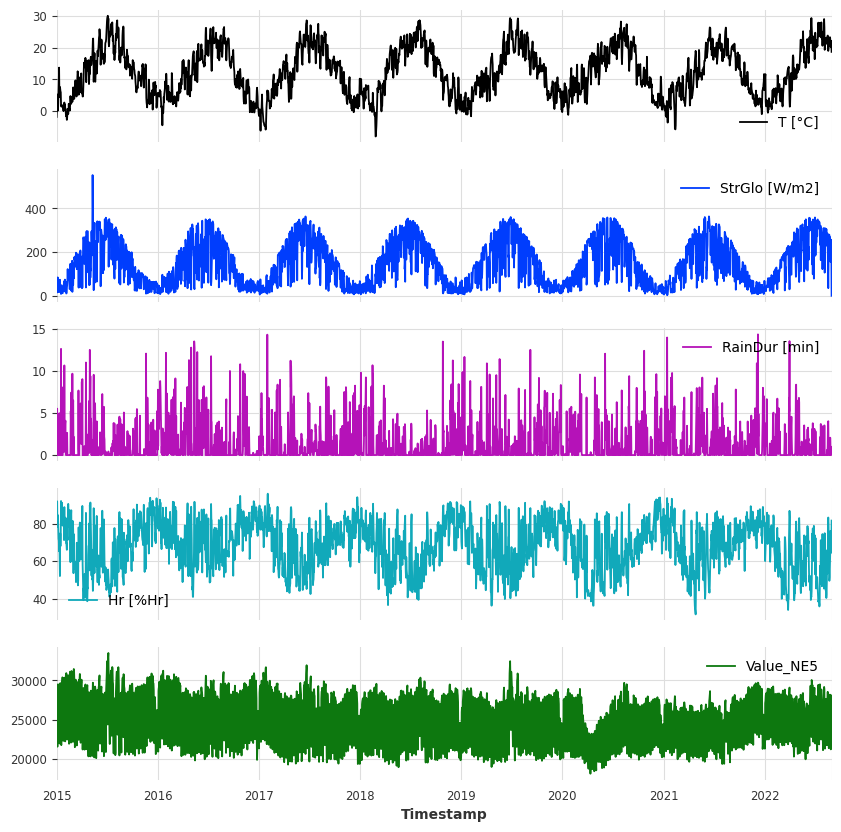

In [86]:
cov = ["T [°C]", "StrGlo [W/m2]", "RainDur [min]", "Hr [%Hr]"]
target = ["Value_NE5"]

zurich_df[cov+target].plot(subplots=True, figsize=(10,10));

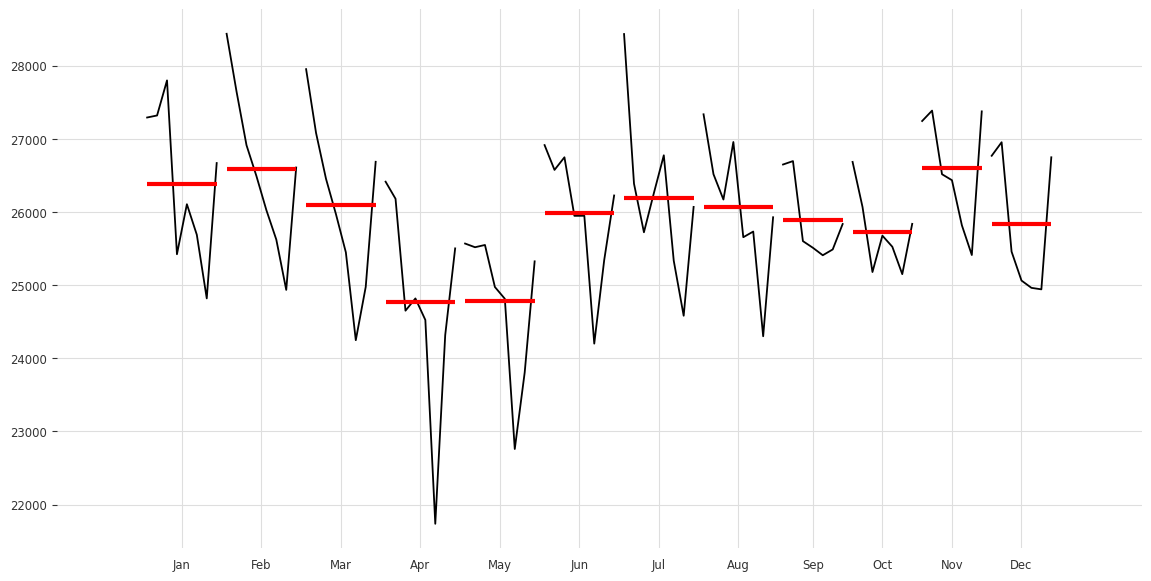

In [87]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

month_plot(zurich_df[target].resample('ME').mean());

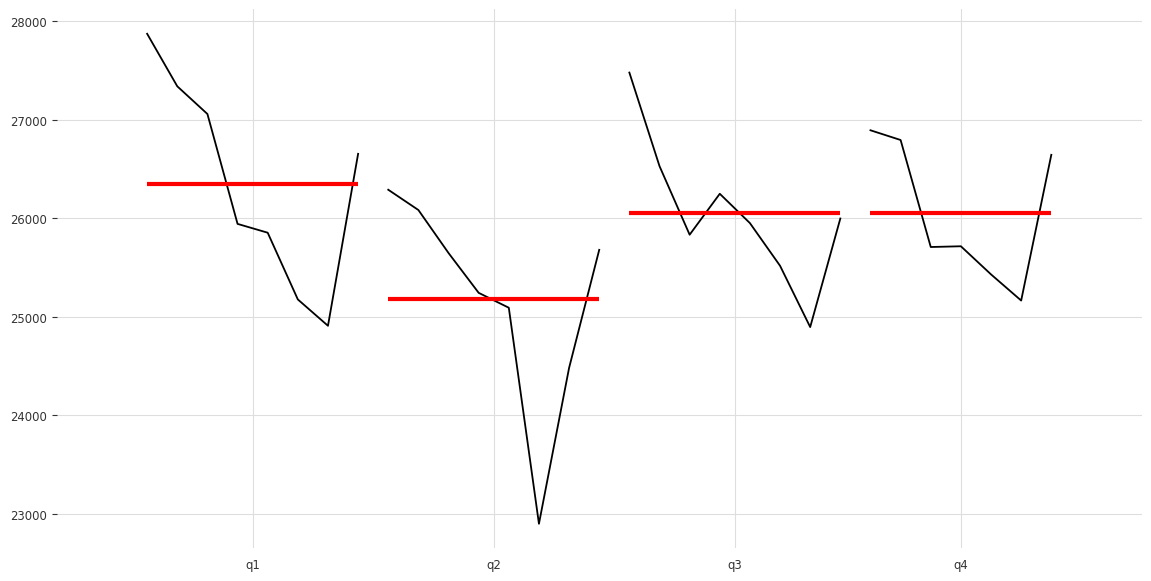

In [88]:
quarter_plot(zurich_df[target].resample('QE').mean());

In [136]:
def split_ts(data, test_size, val_size):
    n_total = len(data)
    test_start = n_total - test_size
    val_start = test_start - val_size

    train = data[:val_start]
    val = data[val_start:test_start]
    test = data[test_start:]

    return train, val, test

In [137]:
zurich_cov = zurich[cov]
zurich_en = zurich[target]

# Create splits maintaining temporal order
d_zen_train, d_zen_val, d_zen_test = split_ts(zurich_en, 30, 160)

print(f'''
Zurich Energy train: {len(d_zen_train)}
Zurich Energy val : {len(d_zen_val)}
Zurich Energy test: {len(d_zen_test)}''')

d_cov_train, d_cov_val, d_cov_test = split_ts(zurich_cov, 30, 160)

print(f'''
Zurich Covariates train: {len(d_cov_train)}
Zurich Covariates val : {len(d_cov_val)}
Zurich Covariates test: {len(d_cov_test)}''')


Zurich Energy train: 2610
Zurich Energy val : 160
Zurich Energy test: 30

Zurich Covariates train: 2610
Zurich Covariates val : 160
Zurich Covariates test: 30


In [98]:
scaler_target = Scaler(StandardScaler())

d_zen_train_sc= scaler_target.fit_transform(d_zen_train)
d_zen_val_sc = scaler_target.transform(d_zen_val)
d_zen_test_sc = scaler_target.transform(d_zen_test)

# Covariates time series 
scaler_cov = Scaler(StandardScaler())

d_cov_train_sc = scaler_cov.fit_transform(d_cov_train)
d_cov_val_sc = scaler_cov.transform(d_cov_val)
d_cov_test_sc = scaler_cov.transform(d_cov_test)

### Define Model Params

In [102]:
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"gpu", "devices": [0], # Use GPU for training
    #"accelerator":"cpu" # Use CPU for training
}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }


In [103]:
model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=120,
    output_chunk_length=30,
    n_rnn_layers=2,
    hidden_dim=32,
    dropout=0.2,
    batch_size=32,
    n_epochs=500,
    optimizer_kwargs={"lr": 0.001},
    model_name="Zur_BlockRNN",
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs 
)           



In [104]:
%%time
# Fit the model with transformed target data and covariates
model.fit(
    series=d_zen_train_sc,
    past_covariates=d_cov_train_sc,
    val_series=d_zen_val_sc,
    val_past_covariates=d_cov_val_sc, 
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 13.4 K | train
6 | fc              | Sequential       | 990    | train
-------------------------------------------------------------
14.4 K    Trainable params
0         Non-trainable params
14.4 K    Total params
0.058     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 54.32it/s, v_num=logs, train_loss=0.765]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 53.70it/s, v_num=logs, train_loss=0.765, val_loss=0.627]

Metric val_loss improved. New best score: 0.627


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.34it/s, v_num=logs, train_loss=0.337, val_loss=0.627]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 58.70it/s, v_num=logs, train_loss=0.337, val_loss=0.246]

Metric val_loss improved by 0.380 >= min_delta = 0.001. New best score: 0.246


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 52.10it/s, v_num=logs, train_loss=0.244, val_loss=0.246]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 51.68it/s, v_num=logs, train_loss=0.244, val_loss=0.152]

Metric val_loss improved by 0.095 >= min_delta = 0.001. New best score: 0.152


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.13it/s, v_num=logs, train_loss=0.277, val_loss=0.152]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 58.45it/s, v_num=logs, train_loss=0.277, val_loss=0.113]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 0.113


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 58.03it/s, v_num=logs, train_loss=0.200, val_loss=0.113]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 57.29it/s, v_num=logs, train_loss=0.200, val_loss=0.093]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.093


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.94it/s, v_num=logs, train_loss=0.258, val_loss=0.093]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.37it/s, v_num=logs, train_loss=0.258, val_loss=0.088]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.088


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.97it/s, v_num=logs, train_loss=0.204, val_loss=0.088]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.43it/s, v_num=logs, train_loss=0.204, val_loss=0.0839]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.084


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.16it/s, v_num=logs, train_loss=0.200, val_loss=0.0839]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.30it/s, v_num=logs, train_loss=0.194, val_loss=0.0869]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.84it/s, v_num=logs, train_loss=0.190, val_loss=0.0842]
Valid

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.080


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 63.63it/s, v_num=logs, train_loss=0.193, val_loss=0.0796]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 62.97it/s, v_num=logs, train_loss=0.193, val_loss=0.0776]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.078


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.04it/s, v_num=logs, train_loss=0.177, val_loss=0.0776]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 60.39it/s, v_num=logs, train_loss=0.177, val_loss=0.0748]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.075


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 60.81it/s, v_num=logs, train_loss=0.205, val_loss=0.0748]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 62.52it/s, v_num=logs, train_loss=0.145, val_loss=0.0762]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.89it/s, v_num=logs, train_loss=0.145, val_loss=0.0723]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.072


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.83it/s, v_num=logs, train_loss=0.191, val_loss=0.0723]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 63.10it/s, v_num=logs, train_loss=0.182, val_loss=0.0735]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 62.47it/s, v_num=logs, train_loss=0.182, val_loss=0.0708]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.071


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 63.69it/s, v_num=logs, train_loss=0.171, val_loss=0.0708]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 63.09it/s, v_num=logs, train_loss=0.171, val_loss=0.069]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.069


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 62.74it/s, v_num=logs, train_loss=0.233, val_loss=0.069]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 59.47it/s, v_num=logs, train_loss=0.173, val_loss=0.0703]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 61.70it/s, v_num=logs, train_loss=0.237, val_loss=0.0689]
Valid

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.067


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 62.52it/s, v_num=logs, train_loss=0.171, val_loss=0.0667]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 58.22it/s, v_num=logs, train_loss=0.175, val_loss=0.0684]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 57.81it/s, v_num=logs, train_loss=0.160, val_loss=0.0669]
Valid

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.067. Signaling Trainer to stop.


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 57.77it/s, v_num=logs, train_loss=0.174, val_loss=0.0707]
CPU times: user 32.6 s, sys: 3.36 s, total: 36 s
Wall time: 48 s


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_BlockRNN, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x127f227e0>], 'enable_progress_bar': True, 'accelerator': 'gpu', 'devices': [0]})

In [106]:
zen_best_model = model.load_from_checkpoint(
                               model_name="Zur_BlockRNN", 
                               best=True)
zen_best_model

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_BlockRNN, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3608a5670>], 'enable_progress_bar': True, 'accelerator': 'gpu', 'devices': [0]})

In [107]:
d_zen_train_val_sc = d_zen_train_sc.append(d_zen_val_sc)
d_cov_train_val_sc = d_cov_train_sc.append(d_cov_val_sc)

zen_forecast_sc = zen_best_model.predict(
    n=len(d_zen_test_sc),
    series=d_zen_train_val_sc,
    past_covariates=d_cov_train_val_sc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.76it/s]


<Axes: xlabel='Timestamp'>

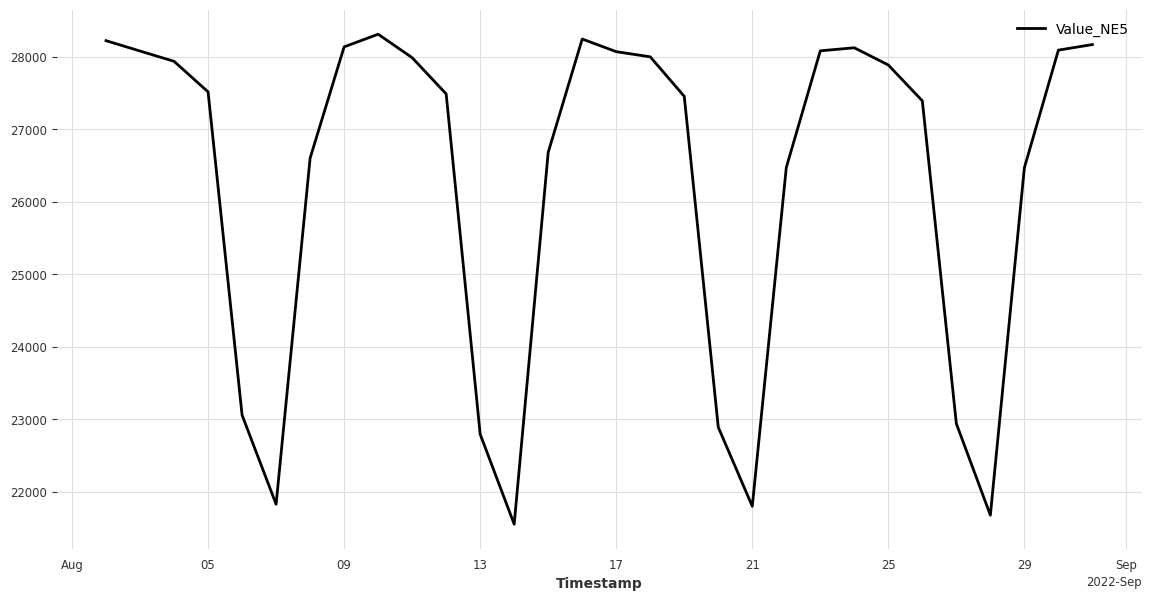

In [108]:
zen_forecast_inv = scaler_target.inverse_transform(zen_forecast_sc)
zen_forecast_inv.plot()

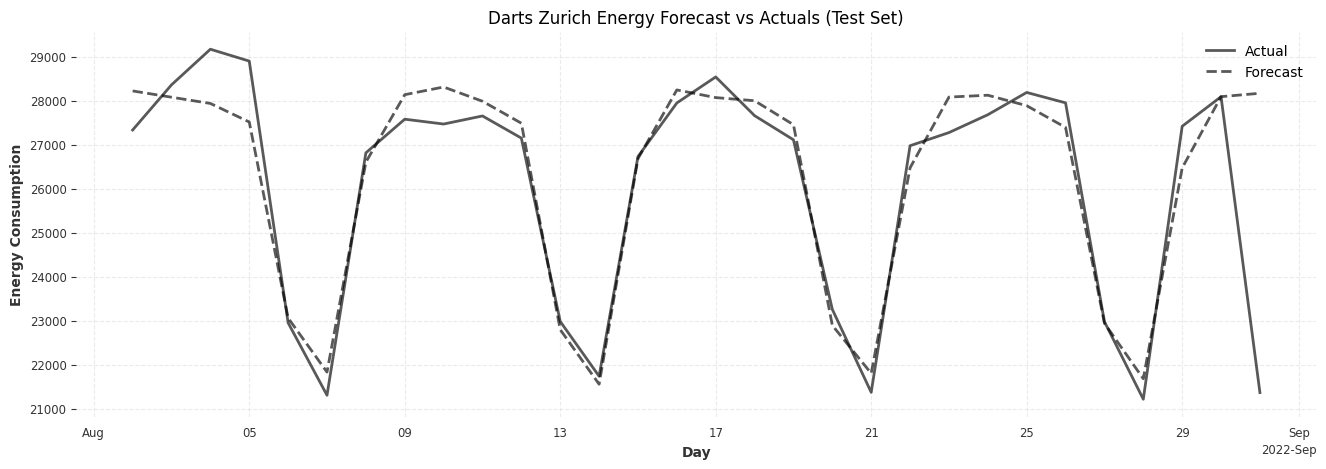

In [109]:
plt.figure(figsize=(16, 5))
d_zen_test.plot(label='Actual', linestyle='-', alpha=0.65)
zen_forecast_inv.plot(label='Forecast', color='k', linestyle='--', alpha=0.65)
plt.title('Darts Zurich Energy Forecast vs Actuals (Test Set)')
plt.xlabel('Day')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [110]:
rmse_val = rmse(d_zen_test, zen_forecast_inv)
mae_val = mae(d_zen_test, zen_forecast_inv)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")

Darts Validation Set MAE:  674.6464
Darts Validation Set RMSE: 1363.5563


## NeuralForecast

In [111]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM as NF_LSTM
from neuralforecast.losses.pytorch import MAE, MSE
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

logger = TensorBoardLogger("nf_tensorboard_log", name="LSTM_Multi")

In [112]:
zurich_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2800 entries, 2015-01-01 to 2022-08-31
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Value_NE5      2800 non-null   float64
 1   Value_NE7      2800 non-null   float64
 2   Hr [%Hr]       2800 non-null   float64
 3   RainDur [min]  2800 non-null   float64
 4   StrGlo [W/m2]  2800 non-null   float64
 5   T [°C]         2800 non-null   float64
 6   WD [°]         2800 non-null   float64
 7   WVs [m/s]      2800 non-null   float64
 8   WVv [m/s]      2800 non-null   float64
 9   p [hPa]        2800 non-null   float64
dtypes: float64(10)
memory usage: 240.6 KB


In [113]:
zurich_df = zurich_df[target+cov].reset_index()

In [114]:
zurich_df.head()

component,Timestamp,Value_NE5,T [°C],StrGlo [W/m2],RainDur [min],Hr [%Hr]
0,2015-01-01,22354.731418,-1.820833,20.546875,0.000000,87.858646
1,2015-01-02,23320.701358,0.948750,26.653229,4.643125,91.988854
2,2015-01-03,23192.982694,5.255208,15.165104,5.505625,91.880833
3,2015-01-04,21553.051314,4.378438,47.625521,1.090417,78.207396
4,2015-01-05,29087.230930,0.906563,84.143854,0.000000,80.368646


In [115]:
zurich_df.rename(columns={'Timestamp': 'ds', 'Value_NE5': 'y'}, inplace=True)
zurich_df['unique_id'] = 'ZurichEnergy'
zurich_df.head()

component,ds,y,T [°C],StrGlo [W/m2],RainDur [min],Hr [%Hr],unique_id
0,2015-01-01,22354.731418,-1.820833,20.546875,0.000000,87.858646,ZurichEnergy
1,2015-01-02,23320.701358,0.948750,26.653229,4.643125,91.988854,ZurichEnergy
2,2015-01-03,23192.982694,5.255208,15.165104,5.505625,91.880833,ZurichEnergy
3,2015-01-04,21553.051314,4.378438,47.625521,1.090417,78.207396,ZurichEnergy
4,2015-01-05,29087.230930,0.906563,84.143854,0.000000,80.368646,ZurichEnergy


In [116]:
TEST_LENGTH=30
WINDOW_SIZE=120

nf_zurich_test = zurich_df.iloc[-TEST_LENGTH:]
nf_zurich_train = zurich_df.iloc[:-TEST_LENGTH]

In [117]:
import math

batch_size = 32
steps_per_epoch = math.ceil(len(nf_zurich_train) / batch_size)
steps_per_epoch

87

In [118]:
# Add checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    mode="min",
    save_top_k=1)

In [119]:
# NeuralForecast LSTM parameters
PATIENCE = 15
nf_lstm_params = {
    'h': TEST_LENGTH, 
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, 
    'encoder_hidden_size': 32, 
    'encoder_dropout': 0.2, 
    'max_steps': steps_per_epoch * 500, 
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, 
    'val_check_steps': steps_per_epoch,
    'scaler_type': 'standard', 
    'random_seed': 42, 
    'logger': logger, 
    'enable_checkpointing': True,
    'callbacks': [checkpoint_callback],
    'futr_exog_list': cov
}
# Instantiate the NeuralForecast LSTM model
nf_lstm = NF_LSTM(**nf_lstm_params)


# Define the models to be used in NeuralForecast
models = [nf_lstm]

# Create the NeuralForecast object
nf_lstm_model = NeuralForecast(models=models, freq='D')



Seed set to 42


In [120]:
%%time
# Fit the model. 
#NeuralForecast handles data splitting internally for validation
nf_lstm_model.fit(df=nf_zurich_train, val_size= 160) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 13.4 K | train
4 | mlp_decoder  | MLP           | 4.9 K  | train
-------------------------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.76it/s, v_num=0, train_loss_step=0.444, train_loss_epoch=0.447]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 173: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s, v_num=0, train_loss_step=0.282, train_loss_epoch=0.291, valid_loss=1.72e+3]
Validation: |                                                                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 260: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.281, valid_loss=1.15e+3]
Valid

In [121]:
fut_cov = nf_zurich_test.drop(columns=['y'])
nf_pred = nf_lstm_model.predict(futr_df=fut_cov)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


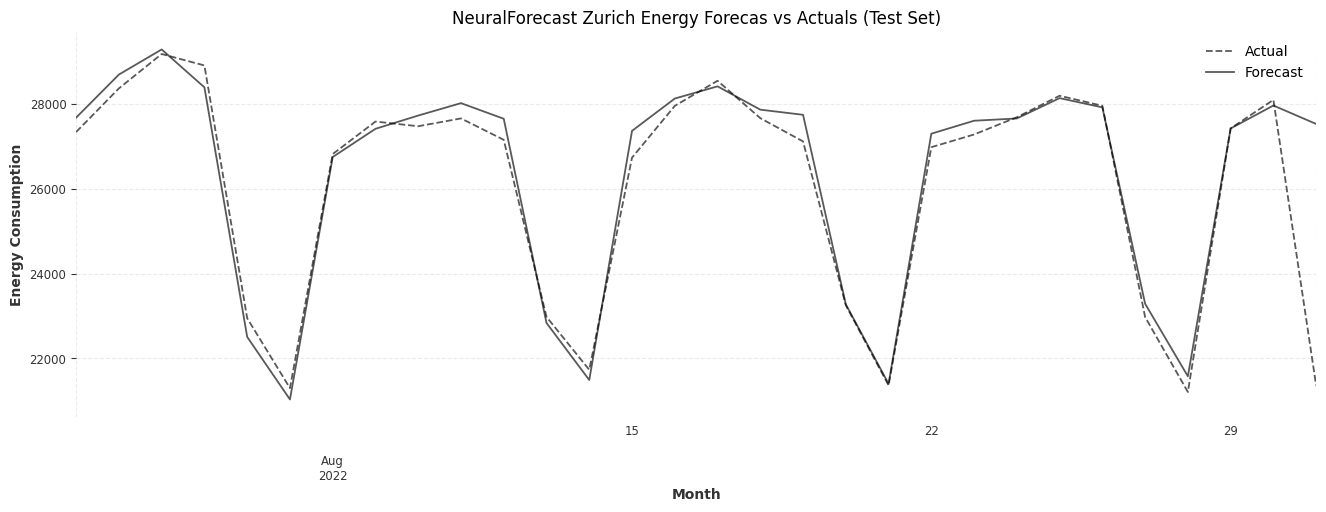

In [139]:
# Prepare the actual test data for plotting
nf_zurich_test.set_index('ds', inplace=True)

plt.figure(figsize=(16, 5))
nf_zurich_test['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_pred.set_index('ds')['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast Zurich Energy Forecas vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [140]:
# Calculate metrics
mae_nf = mean_absolute_error(nf_zurich_test['y'], nf_pred['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(nf_zurich_test['y'], nf_pred['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

NeuralForecast Test Set MAE:  443.0707
NeuralForecast Test Set RMSE: 1163.7069
